# Optical Flow
This notebook presents how to use Dali to calculate optical flow for given sequence of frames.

Let's start with some handy imports

In [1]:
import os.path
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn

from matplotlib import pyplot as plt

Setting metaparameters.  
As an example we use [Sintel trailer](https://durian.blender.org/), included in [DALI_extra](https://github.com/NVIDIA/DALI_extra) repository. Feel free to verify against your own video data.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [2]:
batch_size = 1
sequence_length = 2
dali_extra_path = os.environ['DALI_EXTRA_PATH']
video_filename = dali_extra_path + "/db/optical_flow/sintel_trailer/sintel_trailer_short.mp4"

Functions used for Optical flow visualization.  
The code comes from [Tomrunia's GitHub](https://github.com/tomrunia/OpticalFlow_Visualization "OpticalFlow_Visualization")

In [3]:
def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255 * np.arange(0, RY) / RY)
    col = col + RY
    # YG
    colorwheel[col:col + YG, 0] = 255 - np.floor(255 * np.arange(0, YG) / YG)
    colorwheel[col:col + YG, 1] = 255
    col = col + YG
    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC, 2] = np.floor(255 * np.arange(0, GC) / GC)
    col = col + GC
    # CB
    colorwheel[col:col + CB, 1] = 255 - np.floor(255 * np.arange(CB) / CB)
    colorwheel[col:col + CB, 2] = 255
    col = col + CB
    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM, 0] = np.floor(255 * np.arange(0, BM) / BM)
    col = col + BM
    # MR
    colorwheel[col:col + MR, 2] = 255 - np.floor(255 * np.arange(MR) / MR)
    colorwheel[col:col + MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) + 1
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 1
    f = fk - k0

    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:, i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1 - f) * col0 + f * col1

        idx = (rad <= 1)
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        col[~idx] = col[~idx] * 0.75  # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2 - i if convert_to_bgr else i
        flow_image[:, :, ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:, :, 0]
    v = flow_uv[:, :, 1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)

## Using Dali
### Define the Pipeline.
The pipeline below loads video files and computes optical flow for the sequence of frames.
For more information, please refer to [readers.video](../../supported_ops.html#nvidia.dali.fn.readers.video) and [optical_flow](../../supported_ops.html#nvidia.dali.fn.optical_flow) documentation.

In [4]:
@pipeline_def
def optical_flow_pipe():
    video = fn.readers.video(device="gpu", filenames=video_filename, sequence_length=sequence_length)
    
    f0 = video[0]
    f1 = video[1]
    
    w = 1280
    h = 720
    grid = 4

    fw = 1280 // grid
    fh = 720 // grid

    x = np.arange(fw).reshape([1, fw]) + 0.5
    y = np.arange(fh).reshape([fh, 1]) + 0.5
    xy = np.stack([x, np.zeros_like(x)], axis=2) + np.stack([np.zeros_like(y), y], axis=2)
    xy = xy[np.newaxis] * grid

    m = fn.transforms.rotation(angle=15, center=[w/2, h/2])
    f2 = fn.warp_affine(f1, matrix=m, inverse_map=True)
    
    video2 = fn.stack(f0, f2, axis=0, axis_name='F')
    
    of = fn.optical_flow(video, output_grid=grid)
    of2 = fn.optical_flow(video2, output_grid=grid)
    of3 = fn.coord_transform(of + xy, MT=m) - xy
    
    
    return video, video2, of, of2, of3

### Build and Run DALI Pipeline.

In [5]:
pipe = optical_flow_pipe(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
video, video2, flow, flow2, flow3 = pipe.run()
video = np.array(video[0].as_cpu())
video2 = np.array(video2[0].as_cpu())
flow = np.array(flow[0].as_cpu())
flow2 = np.array(flow2[0].as_cpu())
flow3 = np.array(flow3[0].as_cpu())
print(video.shape)
print(flow.shape)

(2, 720, 1280, 3)
(1, 180, 320, 2)


Above you can see the shape of calculated `flow_vector` (in NFHWC format). It contains 2 channels: flow vector in `x` axis and flow vector in `y` axis. Output resolution is determined by `output_grid` option passed to `optical_flow` operator: for `output_grid = 4`, 4x4 grid is used for flow calculation, thus resolution in every dimension being 4 times smaller, than resolution of the input image.

### Visualize Results

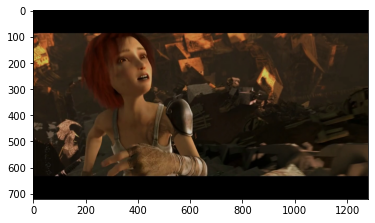

In [6]:
f = 0
plt.imshow(video[f])


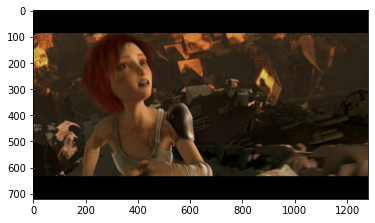

In [7]:
plt.imshow(video[f+1])

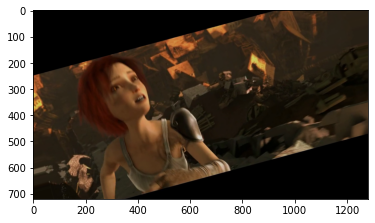

In [8]:
plt.imshow(video2[f+1])

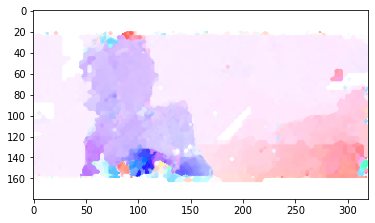

In [9]:
of_result = flow_to_color(flow[f // 2])
plt.imshow(of_result)

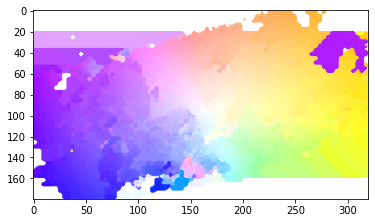

In [10]:
of_result = flow_to_color(flow2[f // 2])
plt.imshow(of_result)

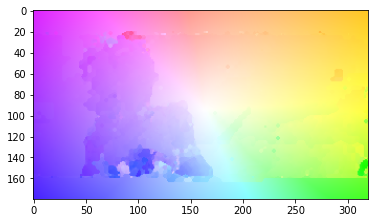

In [11]:
of_result = flow_to_color(flow3[f // 2])
plt.imshow(of_result)